<a href="https://colab.research.google.com/github/abhinavdayal/EIP_Session5/blob/master/Experiment_05_Davidnet_PersonAttributes_multigrad%2C_multilr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 2.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path
import time, math
import tensorflow as tf
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


TensorFlow 2.x selected.


# Import data
Let us import our data and look at the distribution of various categories.

In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
count,13573,13573,13573,13573,13573,13573,13573,13573,13573
unique,2,3,5,4,3,3,4,3,13573
top,male,Average,25-35,normal-healthy,None,Normal,Neutral,Front-Frontish,resized/12255.jpg
freq,7636,7509,5411,8628,7649,6038,9660,8383,1


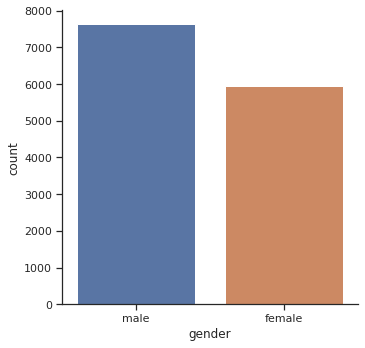

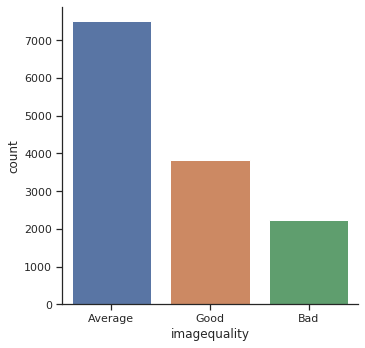

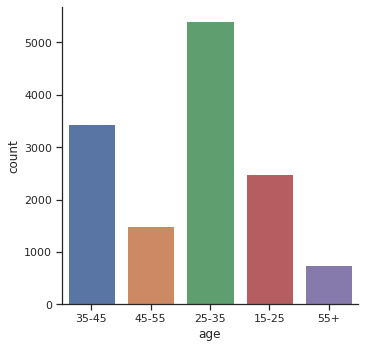

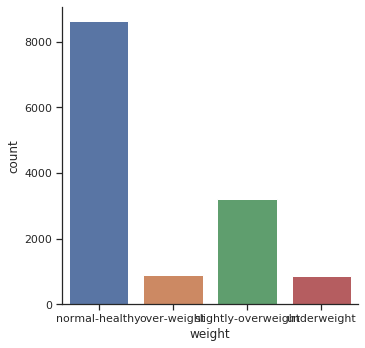

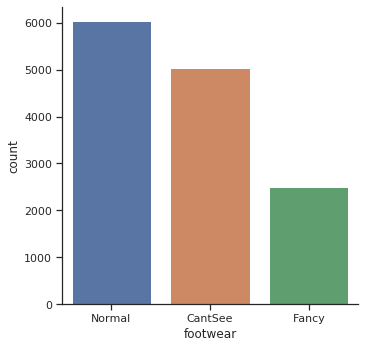

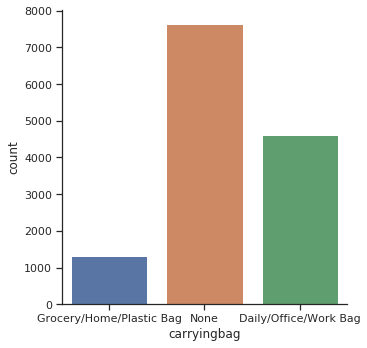

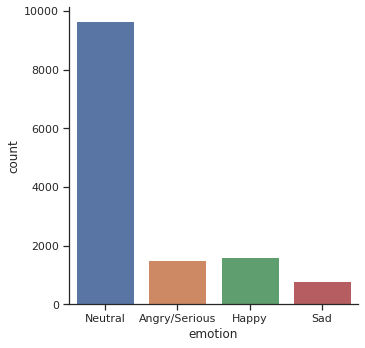

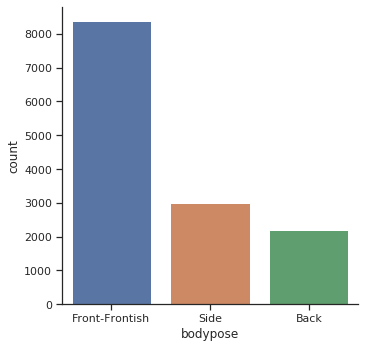

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
sns.catplot(x="gender", kind="count", data=df)
sns.catplot(x="imagequality", kind="count", data=df)
sns.catplot(x="age", kind="count", data=df)
sns.catplot(x="weight", kind="count", data=df)
sns.catplot(x="footwear", kind="count", data=df)
sns.catplot(x="carryingbag", kind="count", data=df)
sns.catplot(x="emotion", kind="count", data=df)
sns.catplot(x="bodypose", kind="count", data=df)
df.describe()

## Observations
From above it is clear that certain categories like emotion, weight, age, carrying bag have some cases of heavily skewed distribution. This will lead the model to bias and not learn so well. It is important to have reasonable and comparable count of training examples in each class.

Let us also see if there are some incorrect examples. Below we sheck if users have given emotion other than Neutral to people with back bodypose.

In [5]:
df[(df.bodypose=="Back") & (df.emotion!='Neutral')]

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
141,male,Bad,15-25,normal-healthy,None,CantSee,Sad,Back,resized/142.jpg
418,female,Average,25-35,normal-healthy,Daily/Office/Work Bag,CantSee,Angry/Serious,Back,resized/419.jpg
446,male,Average,35-45,over-weight,None,CantSee,Angry/Serious,Back,resized/447.jpg
450,female,Average,15-25,normal-healthy,Daily/Office/Work Bag,Normal,Happy,Back,resized/451.jpg
828,male,Bad,25-35,slightly-overweight,None,Normal,Sad,Back,resized/829.jpg
...,...,...,...,...,...,...,...,...,...
13082,male,Average,15-25,normal-healthy,Daily/Office/Work Bag,Normal,Happy,Back,resized/13084.jpg
13392,female,Average,25-35,normal-healthy,Daily/Office/Work Bag,Fancy,Angry/Serious,Back,resized/13394.jpg
13497,female,Bad,35-45,over-weight,Grocery/Home/Plastic Bag,CantSee,Sad,Back,resized/13499.jpg
13502,male,Bad,45-55,slightly-overweight,Daily/Office/Work Bag,Fancy,Sad,Back,resized/13504.jpg


There are 111 such wrong examples. Let us vew them as pics

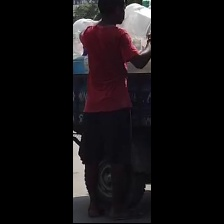

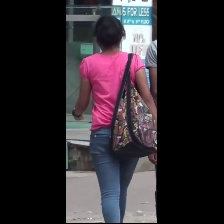

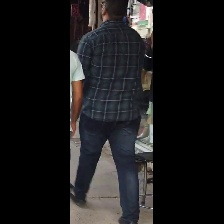

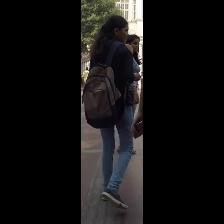

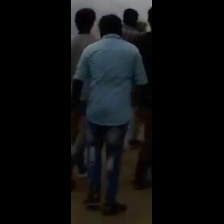

In [6]:
eg = df[(df.bodypose=="Back") & (df.emotion!='Neutral')]
for i in range(5):
  path = eg.iloc[i]['image_path']
  image = cv2.imread(path)
  cv2_imshow(image) 

Sounds about they all should be neutral emotion. Let us look at some more

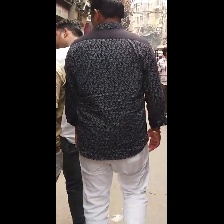

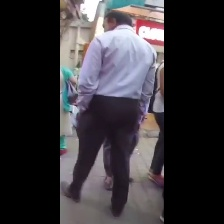

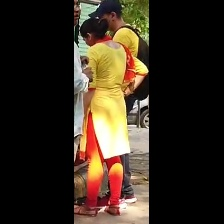

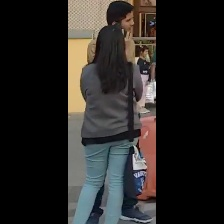

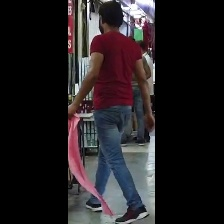

In [7]:
for i in range(5,10):
  path = eg.iloc[i]['image_path']
  image = cv2.imread(path)
  cv2_imshow(image) 

So let us make that change now

In [8]:
df.loc[df.bodypose=="Back", "emotion"] = "Neutral" # correct wrong annotation
df[(df.bodypose=="Back") & (df.emotion!='Neutral')] # verify

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path


# Data Preprocessing
Let us duplicate our data so as to kind of make the classes comparable. We will later do image augmentation to make this duplication effective.

## Categorical mapping
Let us first map our data into numeric categories rather than textual categories as ML wont work directly on strings!

In [9]:
cat_df = pd.concat([
    df[["image_path"]]
], axis=1)
cat_df['gender'] = df.gender.astype('category').cat.codes
cat_df['imagequality'] = df.imagequality.astype('category').cat.codes
cat_df['age'] = df.age.astype('category').cat.codes
cat_df['weight'] = df.weight.astype('category').cat.codes
cat_df['carryingbag'] = df.carryingbag.astype('category').cat.codes
cat_df['footwear'] = df.footwear.astype('category').cat.codes
cat_df['emotion'] = df.emotion.astype('category').cat.codes
cat_df['bodypose'] = df.bodypose.astype('category').cat.codes
cat_df.head()

,image_path,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose
0,resized/1.jpg,1,0,2,0,1,2,2,1
1,resized/2.jpg,0,0,2,1,2,2,0,1
2,resized/3.jpg,1,2,3,0,1,0,2,1
3,resized/4.jpg,1,2,3,0,0,2,2,1
4,resized/5.jpg,0,2,2,2,2,0,2,1


Let us not list what numbers pandas have given to each class, we will use this info to manipulate our data.

In [10]:
num_units = {
    'gender': df.gender.astype('category').cat.categories,
    'imagequality': df.imagequality.astype('category').cat.categories,
    'age': df.age.astype('category').cat.categories,
    'weight': df.weight.astype('category').cat.categories,
    'carryingbag': df.carryingbag.astype('category').cat.categories,
    'footwear': df.footwear.astype('category').cat.categories,
    'emotion': df.emotion.astype('category').cat.categories,
    'bodypose': df.bodypose.astype('category').cat.categories
}

num_units

{'age': Index(['15-25', '25-35', '35-45', '45-55', '55+'], dtype='object'),
 'bodypose': Index(['Back', 'Front-Frontish', 'Side'], dtype='object'),
 'carryingbag': Index(['Daily/Office/Work Bag', 'Grocery/Home/Plastic Bag', 'None'], dtype='object'),
 'emotion': Index(['Angry/Serious', 'Happy', 'Neutral', 'Sad'], dtype='object'),
 'footwear': Index(['CantSee', 'Fancy', 'Normal'], dtype='object'),
 'gender': Index(['female', 'male'], dtype='object'),
 'imagequality': Index(['Average', 'Bad', 'Good'], dtype='object'),
 'weight': Index(['normal-healthy', 'over-weight', 'slightly-overweight', 'underweight'], dtype='object')}

Let us split data into train and test

In [11]:
train_df, val_df = train_test_split(cat_df, test_size=0.15, shuffle=True, random_state=40)
print(train_df.shape, val_df.shape)
len_train = train_df.shape[0]
len_test = val_df.shape[0] 

(11537, 9) (2036, 9)


We shall now duplicate data that has very few examples, some number of times based on our observation in plots above.

But before that, we will calculate mean and standard deviation of original training data. After duplication, it will approximately be the same only.

In [0]:
# here we shall calculate incremental mean and variances so as to normalize data
# we are doing this otherwise the entire data will be loaded in memory at one time
# which can be huge. 
# NOTE: this need only be done once and then the values can be hardcoded.

from tqdm import tnrange, tqdm_notebook
"""
n = 0
s = np.zeros(3)
sq = np.zeros(3)
y = None
for _, item in tqdm_notebook(train_df.iterrows()):
  x = cv2.imread(item["image_path"]).astype('double')
  s += np.sum(x, axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]
  y = x

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))

print(mu, std, n)
"""
mu, std = (np.array([41.33479712, 41.57640031, 46.66141538]), np.array([63.9889454,  64.6502506,  69.85974087]))

OK, Lets try to have a reasonable distribution now

In [13]:
o = train_df[(train_df.emotion!=2)]
for i in range(5):train_df = train_df.append(o)
o = train_df[(train_df.bodypose==0)]
train_df = train_df.append(o)
o = train_df[(train_df.bodypose!=1)]
train_df = train_df.append(o)
o = train_df[(train_df.age==4) | (train_df.age==3)]
train_df = train_df.append(o)
o = train_df[(train_df.carryingbag==1)]
for i in range(2): train_df = train_df.append(o)
o = train_df[(train_df.weight==1) | (train_df.weight==3)]
for i in range(2): train_df = train_df.append(o)

train_df.describe()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose
count,71470.000000,71470.000000,71470.000000,71470.000000,71470.000000,71470.000000,71470.000000,71470.000000
mean,0.567399,0.763677,1.847307,1.074003,1.252176,1.014230,1.409067,1.147838
std,0.495440,0.889653,1.250640,1.129485,0.835336,0.909731,1.025201,0.678400
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000
75%,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,2.000000,4.000000,3.000000,2.000000,2.000000,3.000000,2.000000


OK, That gave us 7 times as much data, which is nice to work with!

We need to shuffle this data now so that there is no bias in batches.

In [14]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,image_path,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose
0,resized/3314.jpg,1,0,1,2,2,2,1,1
1,resized/8310.jpg,1,2,1,3,2,0,1,1
2,resized/5930.jpg,0,1,1,2,2,2,2,1
3,resized/7119.jpg,1,2,3,1,0,1,0,1
4,resized/2511.jpg,1,0,2,0,1,2,0,1


Let us look at new distributions.

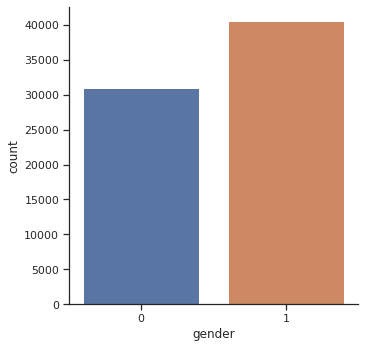

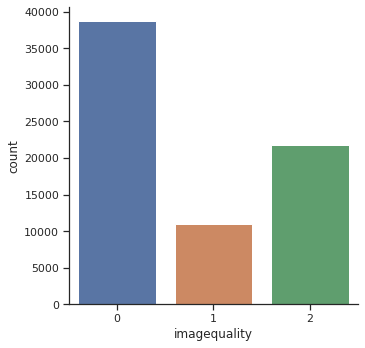

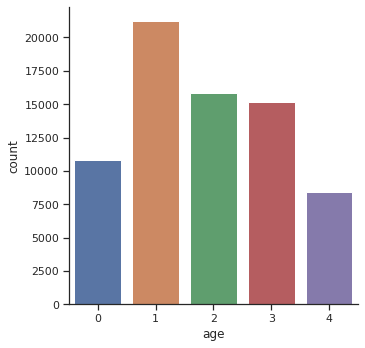

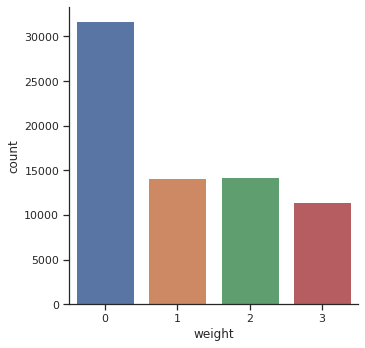

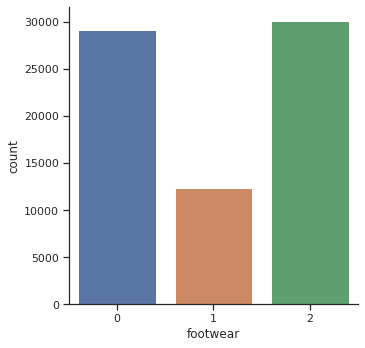

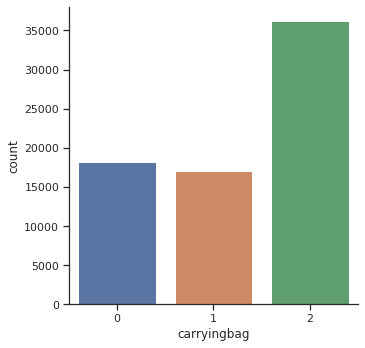

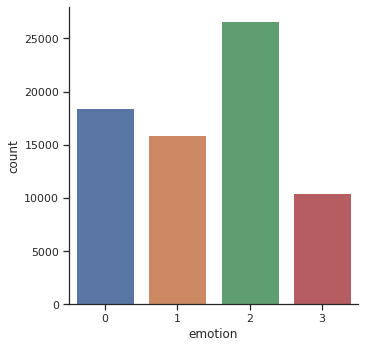

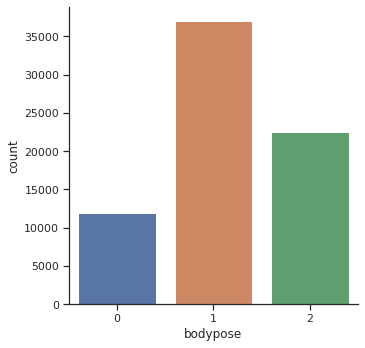

In [15]:
sns.catplot(x="gender", kind="count", data=train_df)
sns.catplot(x="imagequality", kind="count", data=train_df)
sns.catplot(x="age", kind="count", data=train_df)
sns.catplot(x="weight", kind="count", data=train_df)
sns.catplot(x="footwear", kind="count", data=train_df)
sns.catplot(x="carryingbag", kind="count", data=train_df)
sns.catplot(x="emotion", kind="count", data=train_df)
sns.catplot(x="bodypose", kind="count", data=train_df)

Looks much better. Imagequality may be a bit less for "good" but let us work with it for now.

# Data Generator and Image Augmentation
Let us work on our data augmentation inclusing cutouts. Below is modification of method 
[get_random_eraser](https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py)

All we are doing is that we are replacing the cutout region with mean. After normalizing mean must be 0. We will call this method only after normalizing the image.

In [0]:
class image_processor():
    def rolldie(self, p):
      p_1 = np.random.rand()
      if p_1 > p:
          return False
      return True

    def adjust(self, start, span, dim_len):
      if start + span > dim_len:
          if start-span >= 0:
            start = start-span
          else:
            if self.rolldie(0.5):
              start -= (start+span) - dim_len
            else:
              start = 0

      return start

    def region(self, img_w, img_h, s_l, s_h, r_1=1, r_2=1):
        s = np.random.uniform(s_l, s_h) * img_h * img_w #area to cutout
        #print(s)
        if r_1==1 and r_2==1:
          r = img_h/img_w # use image aspect only
        else:
          r = np.random.uniform(r_1, r_2) # aspect ratio
        w = int(np.sqrt(s / r)) # width of cutout
        h = int(np.sqrt(s * r)) # height of cutout
        
        left = self.adjust(np.random.randint(0, img_w), w, img_w) # start
        top = self.adjust(np.random.randint(0, img_h), h, img_h) # end

        #print(left, top, left+w, top+h)
        return (left, top, w, h)

    

    def cutout(self, input_img, p=0.5, s_l=0.04, s_h=0.08, r_1=0.3, r_2=1/0.3):
        if self.rolldie(p):
          return input_img

        avg_color = np.array([0,0,0]).astype('float32')
        img_h, img_w, img_c = input_img.shape

        left, top, w, h = self.region(img_w, img_h, s_l, s_h, r_1, r_2)

        #print(top, left, h, w)
        input_img[top:top + h, left:left + w, :] = avg_color

        return input_img

    def zoom(self, input_img, p=0.5, s_l=0.75, s_h=0.95):
        if self.rolldie(p):
          return input_img
        img_h, img_w, img_c = input_img.shape

        left, top, w, h = self.region(img_w, img_h, s_l, s_h)

        # crop and resize
        return  cv2.resize(input_img[top:top + h, left:left + w, :], (img_h, img_w), cv2.INTER_CUBIC)



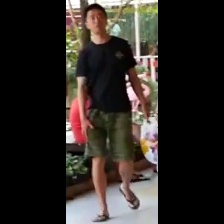

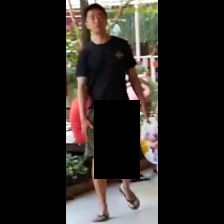

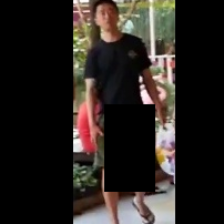

In [17]:
#TEST
im = cv2.imread(df.iloc[0]['image_path'])
cv2_imshow(im)
p = image_processor()
a = p.cutout(im)

cv2_imshow(a) 
b = p.zoom(im)
cv2_imshow(b) 

In [68]:
tf.executing_eagerly()

True

Next we shall work on our person data generator that returns a single batch

In [0]:
class PersonDataGenerator(tf.keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, train_mean, train_std, batch_size=32, shuffle=False, training=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train_mean = train_mean
        self.train_std = train_std
        self.training = training
        self.imp = image_processor()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = []
        for image in [cv2.imread(item["image_path"]).astype('float32') for _, item in items.iterrows()]:
          
          # augment for training but not for test
          if self.training:
            image = self.imp.cutout(image)
            image = self.imp.zoom(image)
            image = tf.image.random_brightness(image, max_delta=0.3)
            image = tf.image.random_flip_left_right(image) # horizontal flipping

          # normalize
          image = ((image-self.train_mean)/self.train_std)


            # TODO: try other types of augmentation as well
          images.append(image)


        target = np.stack(
            [items['gender'].values,
            items['imagequality'].values,
            items['age'].values,
            items['weight'].values,
            items['carryingbag'].values,
            items['footwear'].values,
            items['emotion'].values,
            items['bodypose'].values],
            axis = 0
        ).astype('int32')

        images = np.stack(images, axis=0)
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        # since we have already shuffled, we want to send all images in every batch
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE =  0.01#@param {type:"number"}
WEIGHT_DECAY = 9e-4 #@param {type:"number"}
EPOCHS = 10 #@param {type:"integer"}

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, mu, std, batch_size=BATCH_SIZE)
test_gen = PersonDataGenerator(val_df, mu, std, batch_size=64, shuffle=False, training=False)
len_train = train_df.shape[0]

In [21]:
images, targets = next(iter(train_gen))
print(images.shape, targets.shape)

(32, 224, 224, 3) (8, 32)


In [0]:
# initialize all weights between 0 and 1 of a 3x3xcxd filter uwing kiaming he policy
#https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  # how many filters
  fan = np.prod(shape[:-1])
  
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
# creates a convolution layer with batch normalization and dropouts
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.05)

  def call(self, inputs, training=False):
    h = self.conv(inputs)
    if training:
      h = self.drop(h)
    return tf.nn.relu(self.bn(h))
    
  #def model(self):
  #    x = tf.keras.Input(shape=(224,224,3))
  #    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [0]:
ConvBN(32).model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 224, 224, 32)]    0         
Total params: 992
Trainable params: 928
Non-trainable params: 64
_________________________________________________________________


In [0]:
# This class creates a residual block (if res = true) else regular convolution layer
# It can apply pooling if passed. pool can be identity as well if no pooling is needed.
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h
    
  #def model(self):
  #    x = tf.keras.Input(shape=(56,56,3))
  #    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [0]:
ResBlk(128, tf.keras.layers.MaxPooling2D(), True).model().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv_bn_1 (ConvBN)              (None, 56, 56, 128)  3968        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 28, 28, 128)  0           conv_bn_1[0][0]                  
__________________________________________________________________________________________________
conv_bn_2 (ConvBN)              (None, 28, 28, 128)  147968      max_pooling2d[0][0]              
____________________________________________________________________________________________

In [0]:
ResBlk(128, tf.keras.layers.MaxPooling2D(), False).model().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
conv_bn_4 (ConvBN)           (None, 56, 56, 128)       3968      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0         
Total params: 3,968
Trainable params: 3,712
Non-trainable params: 256
_________________________________________________________________


In [0]:
# since david net is not a deep arcitecture, it is ok for it to have convolution layer in main line in every block.
# for deeper architectures there is problem of vanishing gradients otherwise.
class DavidNet(tf.keras.Model):
  def __init__(self, order, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.pool1 = tf.keras.layers.MaxPooling2D()
    self.pool2 = tf.keras.layers.MaxPooling2D()
    self.conv_bn1 = ConvBN(c)
    self.conv_bn2 = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.gpool = tf.keras.layers.GlobalMaxPool2D()
    self.order = order
    self.weight = weight
    self.out_layers = {}
    for key in self.order:
      self.out_layers[key] = tf.keras.layers.Dense(len(num_units[key]), name=f"{key}_output", kernel_initializer=init_pytorch, use_bias=False)
    """
    {'age': Index(['15-25', '25-35', '35-45', '45-55', '55+'], dtype='object'),
     'bodypose': Index(['Back', 'Front-Frontish', 'Side'], dtype='object'),
     'carryingbag': Index(['Daily/Office/Work Bag', 'Grocery/Home/Plastic Bag', 'None'], dtype='object'),
     'emotion': Index(['Angry/Serious', 'Happy', 'Neutral', 'Sad'], dtype='object'),
     'footwear': Index(['CantSee', 'Fancy', 'Normal'], dtype='object'),
     'gender': Index(['female', 'male'], dtype='object'),
     'imagequality': Index(['Average', 'Bad', 'Good'], dtype='object'),
     'weight': Index(['normal-healthy', 'over-weight', 'slightly-overweight', 'underweight'], dtype='object')}
    """

  def call(self, x, y):
    # inital convolution on inputs with 64 outputs of 32x32
    # followed by resnet block with 128 outpts of 16x16
    # followed by non-residual block with 256 outputs of 8x8
    # followed by residual block with 512 outputs of 4x4
    # followed by a global max pooling that is going to flatten the 5x5x512 channles to 1x512 picking only the max in each channel of 4x4
    # actually this happens for a batch so if batch size is 512 it will give 512x512 tensor
    
    h = self.pool1(self.conv_bn1(x)) # 128x128x64
    h = self.pool2(self.conv_bn2(h)) # 56x56x64
    h = self.gpool(self.blk3(self.blk2(self.blk1(h))))

    label_losses = []
    label_corrects = []
    i = 0
    for output in self.order:
      # dense layer but why we are multiplying by weight, I am still not clear!!!
      t = self.out_layers[output](h)*self.weight

      # calculate cross entropy
      ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=t, labels=y[i])

      # reduce the tensor by summing up the loss over entire batch. This is our overall loss
      label_losses = tf.concat([label_losses, tf.reshape(tf.reduce_sum(ce), [1])], 0)

      # calculate number of correct observations. This will help calcuate accuracy of training.
      label_corrects = tf.concat([label_corrects, tf.reshape(tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(t, axis = 1), y[i]), tf.float32)), [1])], 0)

      i += 1

    loss = tf.reduce_sum(label_losses)
    correct = tf.reduce_sum(label_corrects)
    
    return loss, correct, label_losses, label_corrects
  #def model(self):
  #      x = tf.keras.Input(shape=(224,224,3))
  #      return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [0]:
DavidNet().model().summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_bn_5 (ConvBN)           (None, 224, 224, 8)       248       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv_bn_7 (ConvBN)           (None, 112, 112, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
res_blk_2 (ResBlk)           (None, 28, 28, 128)       314880    
_________________________________________________________________
res_blk_3 (ResBlk)           (None, 14, 14, 256)       2959

In [0]:
order = cat_df.columns[1:]
model = DavidNet(order)
#model.model().summary()
#https://github.com/tensorflow/tensorflow/issues/25036

In [0]:
#https://github.com/bckenstler/CLR/blob/master/clr_callback.py
# Modified to adapt to subclassed style
class CyclicLR():
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)       
            
    def on_batch_end(self, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(self.clr())
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        #K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
batches_per_epoch = len_train//BATCH_SIZE + 1

global_step = 0
#CLR = CyclicLR(base_lr=0.00001, max_lr=0.02, step_size=2000., mode='triangular')

# global_step/batches_per_epoch will be < 1 for first epoch per batch and between 1-2 for second and so on.
lr_func = lambda: 0.001

# we also must optimize momentum in reverse direction of learning rate
# We are using nestrov momentum here.
opt = tf.keras.optimizers.SGD(lr_func, momentum=MOMENTUM, nesterov=True)
#opt = tf.compat.v1.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

In [0]:
x, y = next(iter(train_gen))

In [134]:
loss, correct, batch_category_losses, batch_category_corrects = model(x, y)
print(loss)
print(correct)
print(batch_category_losses)
print(batch_category_corrects)

tf.Tensor(2424.8496, shape=(), dtype=float32)
tf.Tensor(603.0, shape=(), dtype=float32)
tf.Tensor(
[177.54207 281.41382 412.1231  355.00107 281.31906 281.20178 354.8296
 281.419  ], shape=(8,), dtype=float32)
tf.Tensor([113.  48.  49.  67.  67. 105.  99.  55.], shape=(8,), dtype=float32)


In [0]:
import datetime
def format(t):
  # reject microseconds for better display
  return str(datetime.timedelta(seconds=int(t)))

In [29]:
from keras.utils import plot_model

Using TensorFlow backend.


In [30]:
plot_model(model)

AttributeError: ignored

In [35]:
t = time.time()
numlabels = len(order)
global_step = 0

# history recording for plotting curves
train_loss_history = {'total':[]}
test_loss_history = {'total':[]}
train_acc_history = {'total':[]}
test_acc_history = {'total':[]}

for key in num_units:
  train_loss_history[key] = []
  test_loss_history[key] = []
  train_acc_history[key] = []
  test_acc_history[key] = []


for epoch in tnrange(EPOCHS):
  train_loss = test_loss = train_correct = test_correct = 0.0
  category_train_loss = np.zeros(len(order))
  category_train_correct = np.zeros(len(order))
  category_test_loss = np.zeros(len(order))
  category_test_correct = np.zeros(len(order))

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm_notebook(train_gen):
    with tf.GradientTape(persistent=True) as tape:
      # calculate the outputs for this batch
      loss, correct, batch_category_losses, batch_category_corrects = model(x, y)

    # Now we need to update the training variables of model using back propagation
    var = model.trainable_variables

    # we will apply separate gradiens to backbone and each output neck
    # TODO: use different LR for each category. This can be done using multiple instance of optimizers.
    backbone_vars = var[:-numlabels]
    output_vars = var[-numlabels:]
    # now calculate and apply output layer gradients separately
    grads = tape.gradient(batch_category_losses, output_vars)
    # implement weight decay, but why multiply by batch size?
    for g, v in zip(grads, output_vars):
      g += v * WEIGHT_DECAY * BATCH_SIZE

    # apply the momentum. This updates the gradients for us
    opt.apply_gradients(zip(grads, output_vars))

    # calculate the gradients of loss vs the trainable_variables
    # tensorflow does it for us, differentiating loss against reach variable. Amazing!
    grads = tape.gradient(loss, backbone_vars)
    # implement weight decay, but why multiply by batch size?
    for g, v in zip(grads, backbone_vars):
      g += v * WEIGHT_DECAY * BATCH_SIZE

    # apply the momentum. This updates the gradients for us
    opt.apply_gradients(zip(grads, backbone_vars))

    

    del tape # drop the reference to tape

    global_step += 1

    train_loss += loss.numpy()
    train_correct += correct.numpy()
    category_train_loss += batch_category_losses.numpy()
    category_train_correct += batch_category_corrects.numpy()

    # set one batch over for cyclic learning rate
    #CLR.on_batch_end()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in tqdm_notebook(test_gen):
    loss, correct, batch_category_losses, batch_category_corrects = model(x, y)
    test_loss += loss.numpy()
    test_correct += correct.numpy()
    category_test_loss += batch_category_losses.numpy()
    category_test_correct += batch_category_corrects.numpy()
  
  train_loss_history['total'].append(train_loss / (len_train*numlabels))
  test_loss_history['total'].append(test_loss / (len_test*numlabels))
  train_acc_history['total'].append(train_correct / (len_train*numlabels))
  test_acc_history['total'].append(test_correct / (len_test*numlabels))

  print(f"\nEPOCH:{epoch+1}, global_step = {global_step}, lr: {lr_func()}, train loss: {train_loss_history['total'][epoch]:.2f}, train acc: {train_acc_history['total'][epoch]:.2f}, val loss: {test_loss_history['total'][epoch]:.2f}, val acc: {test_acc_history['total'][epoch]:.2f}, time: {format(time.time() - t)}")
  for i in range(len(order)):
    k = order[i]
    train_loss_history[k].append(category_train_loss[i]/len_train)
    test_loss_history[k].append(category_test_loss[i]/len_test)
    train_acc_history[k].append(category_train_correct[i]/len_train)
    test_acc_history[k].append(category_test_correct[i]/len_test)
    print(f"{(k+'_output').upper()}: [TRAIN] loss: {train_loss_history[k][epoch]:.2f}, acc: {train_acc_history[k][epoch]:.2f}, [TEST] loss: {test_loss_history[k][epoch]:.2f}, acc: {test_acc_history[k][epoch]:.2f}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


EPOCH:1, global_step = 2233, lr: 0.001, train loss: 0.98, train acc: 0.55, val loss: 0.93, val acc: 0.56, time: 0:16:28
GENDER_OUTPUT: [TRAIN] loss: 0.48, acc: 0.75, [TEST] loss: 0.48, acc: 0.75
IMAGEQUALITY_OUTPUT: [TRAIN] loss: 0.94, acc: 0.55, [TEST] loss: 0.90, acc: 0.56
AGE_OUTPUT: [TRAIN] loss: 1.48, acc: 0.34, [TEST] loss: 1.44, acc: 0.36
WEIGHT_OUTPUT: [TRAIN] loss: 1.23, acc: 0.47, [TEST] loss: 1.22, acc: 0.43
CARRYINGBAG_OUTPUT: [TRAIN] loss: 0.97, acc: 0.54, [TEST] loss: 0.92, acc: 0.55
FOOT


EPOCH:2, global_step = 4466, lr: 0.001, train loss: 0.76, train acc: 0.67, val loss: 0.92, val acc: 0.57, time: 0:32:54
GENDER_OUTPUT: [TRAIN] loss: 0.28, acc: 0.88, [TEST] loss: 0.38, acc: 0.82
IMAGEQUALITY_OUTPUT: [TRAIN] loss: 0.81, acc: 0.63, [TEST] loss: 0.96, acc: 0.54
AGE_OUTPUT: [TRAIN] loss: 1.23, acc: 0.48, [TEST] loss: 1.48, acc: 0.38
WEIGHT_OUTPUT: [TRAIN] loss: 0.97, acc: 0.59, [TEST] loss: 1.15, acc: 0.41
CARRYINGBAG_OUTPUT: [TRAIN] loss: 0.77, acc: 0.66, [TEST] loss: 0.87, acc: 0.59
FOOTWEAR_OUTPUT: [TRAIN] loss: 0.68, acc: 0.71, [TEST] loss: 0.87, acc: 0.59
EMOTION_OUTPUT: [TRAIN] loss: 1.00, acc: 0.57, [TEST] loss: 1.09, acc: 0.48
BODYPOSE_OUTPUT: [TRAIN] loss: 0.38, acc: 0.85, [TEST] loss: 0.54, acc: 0.77



EPOCH:3, global_step = 6699, lr: 0.001, train loss: 0.58, train acc: 0.76, val loss: 1.01, val acc: 0.57, time: 0:49:21
GENDER_OUTPUT: [TRAIN] loss: 0.20, acc: 0.92, [TEST] loss: 0.46, acc: 0.80
IMAGEQUALITY_OUTPUT: [TRAIN] loss: 0.66, acc: 0.72, [TEST] loss: 1.06, acc: 0.52
AGE_OUTPUT: [TRAIN] loss: 0.95, acc: 0.62, [TEST] loss: 1.63, acc: 0.39
WEIGHT_OUTPUT: [TRAIN] loss: 0.70, acc: 0.72, [TEST] loss: 1.24, acc: 0.45
CARRYINGBAG_OUTPUT: [TRAIN] loss: 0.56, acc: 0.77, [TEST] loss: 0.92, acc: 0.56
FOOTWEAR_OUTPUT: [TRAIN] loss: 0.55, acc: 0.78, [TEST] loss: 0.93, acc: 0.58
EMOTION_OUTPUT: [TRAIN] loss: 0.74, acc: 0.70, [TEST] loss: 1.27, acc: 0.43
BODYPOSE_OUTPUT: [TRAIN] loss: 0.28, acc: 0.90, [TEST] loss: 0.57, acc: 0.78



EPOCH:4, global_step = 8932, lr: 0.001, train loss: 0.44, train acc: 0.83, val loss: 1.04, val acc: 0.58, time: 1:05:56
GENDER_OUTPUT: [TRAIN] loss: 0.15, acc: 0.94, [TEST] loss: 0.42, acc: 0.84
IMAGEQUALITY_OUTPUT: [TRAIN] loss: 0.51, acc: 0.79, [TEST] loss: 1.14, acc: 0.49
AGE_OUTPUT: [TRAIN] loss: 0.73, acc: 0.72, [TEST] loss: 1.79, acc: 0.38
WEIGHT_OUTPUT: [TRAIN] loss: 0.52, acc: 0.80, [TEST] loss: 1.24, acc: 0.50
CARRYINGBAG_OUTPUT: [TRAIN] loss: 0.42, acc: 0.84, [TEST] loss: 0.96, acc: 0.59
FOOTWEAR_OUTPUT: [TRAIN] loss: 0.44, acc: 0.83, [TEST] loss: 1.02, acc: 0.56
EMOTION_OUTPUT: [TRAIN] loss: 0.53, acc: 0.79, [TEST] loss: 1.22, acc: 0.52
BODYPOSE_OUTPUT: [TRAIN] loss: 0.22, acc: 0.92, [TEST] loss: 0.52, acc: 0.80



EPOCH:5, global_step = 11165, lr: 0.001, train loss: 0.35, train acc: 0.87, val loss: 1.16, val acc: 0.57, time: 1:22:44
GENDER_OUTPUT: [TRAIN] loss: 0.13, acc: 0.95, [TEST] loss: 0.49, acc: 0.82
IMAGEQUALITY_OUTPUT: [TRAIN] loss: 0.41, acc: 0.84, [TEST] loss: 1.25, acc: 0.47
AGE_OUTPUT: [TRAIN] loss: 0.57, acc: 0.79, [TEST] loss: 1.99, acc: 0.39
WEIGHT_OUTPUT: [TRAIN] loss: 0.40, acc: 0.85, [TEST] loss: 1.38, acc: 0.50
CARRYINGBAG_OUTPUT: [TRAIN] loss: 0.33, acc: 0.87, [TEST] loss: 1.04, acc: 0.61
FOOTWEAR_OUTPUT: [TRAIN] loss: 0.35, acc: 0.87, [TEST] loss: 1.11, acc: 0.54
EMOTION_OUTPUT: [TRAIN] loss: 0.40, acc: 0.85, [TEST] loss: 1.48, acc: 0.47
BODYPOSE_OUTPUT: [TRAIN] loss: 0.18, acc: 0.94, [TEST] loss: 0.56, acc: 0.80



EPOCH:6, global_step = 13398, lr: 0.001, train loss: 0.28, train acc: 0.90, val loss: 1.21, val acc: 0.58, time: 1:39:22
GENDER_OUTPUT: [TRAIN] loss: 0.10, acc: 0.96, [TEST] loss: 0.47, acc: 0.83
IMAGEQUALITY_OUTPUT: [TRAIN] loss: 0.34, acc: 0.87, [TEST] loss: 1.36, acc: 0.49
AGE_OUTPUT: [TRAIN] loss: 0.46, acc: 0.83, [TEST] loss: 2.06, acc: 0.35
WEIGHT_OUTPUT: [TRAIN] loss: 0.32, acc: 0.88, [TEST] loss: 1.45, acc: 0.49
CARRYINGBAG_OUTPUT: [TRAIN] loss: 0.27, acc: 0.90, [TEST] loss: 1.20, acc: 0.63
FOOTWEAR_OUTPUT: [TRAIN] loss: 0.29, acc: 0.89, [TEST] loss: 1.20, acc: 0.56
EMOTION_OUTPUT: [TRAIN] loss: 0.31, acc: 0.88, [TEST] loss: 1.37, acc: 0.54
BODYPOSE_OUTPUT: [TRAIN] loss: 0.15, acc: 0.95, [TEST] loss: 0.59, acc: 0.79


KeyboardInterrupt: ignored

In [0]:
category_train_correct

[5598.0, 3730.0, 2330.0, 2951.0, 3696.0, 3834.0, 4094.0, 2837.0]